# **ASSIGNMENT 5(ii)**

Name: Alena Maria Thomas

Roll No: MDS202303

## 1. Import all the required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## 2. Check if GPU is available.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 3. Load the train and test datasets from the Google Drive folder.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/AML_Asgmt_5_datasets/train.csv', encoding='latin-1').dropna()
test_df = pd.read_csv('/content/drive/MyDrive/AML_Asgmt_5_datasets/test.csv', encoding='latin-1').dropna()

In [5]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [6]:
train_df.shape, test_df.shape

((27480, 10), (3534, 9))

## 4. Preprocess the dataset.

The only important columns in the dataset are 'text' and 'sentiment'. So we extract only those columns.

In [7]:
train_df = train_df[['text', 'sentiment']]
test_df = test_df[['text', 'sentiment']]

Map the sentiment to labels.

In [8]:
np.unique(train_df.sentiment)

array(['negative', 'neutral', 'positive'], dtype=object)

In [9]:
sentiment_to_label = {'negative':0, 'neutral':1, 'positive':2}
train_df['sentiment'] = train_df['sentiment'].map(sentiment_to_label)
test_df['sentiment'] = test_df['sentiment'].map(sentiment_to_label)

<ipython-input-9-b8cba3643c2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sentiment'] = train_df['sentiment'].map(sentiment_to_label)
<ipython-input-9-b8cba3643c2d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sentiment'] = test_df['sentiment'].map(sentiment_to_label)


In [10]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [11]:
train_df.sentiment.value_counts()

sentiment
1    11117
2     8582
0     7781
Name: count, dtype: int64

## 5. Split the training dataset into train/validation datasets.

Firstly, we separate the features and the labels.

In [12]:
X = train_df.text.values
y = train_df.sentiment.values

X_test = test_df.text.values
y_test = test_df.sentiment.values

Next, we split the train dataset into train/validation sets.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)

## 6. Tokenize the text.

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Visualizing the lengths of sentences

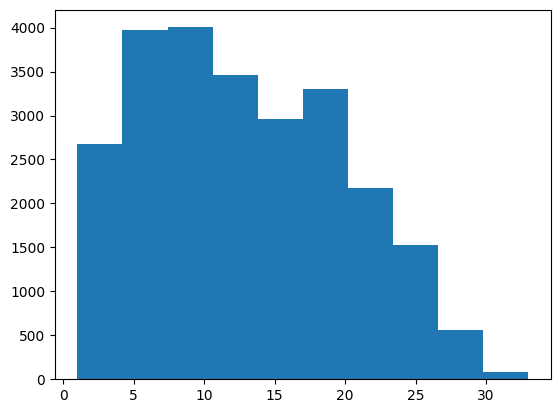

In [15]:
seq_len = [len(i.split()) for i in X_train]
plt.hist(seq_len)
plt.show()

Hence, we take padding with length 30 and tokenize all texts.

In [16]:
def tokenize_text(X, y, tokenizer):
  # tokenize and encode sequences in the dataset
  encoding = tokenizer.batch_encode_plus(
      X,
      max_length = 30,
      pad_to_max_length = True,
      truncation = True
  )

  # convert sequences, attention masks, labels to tensors
  input_ids = torch.tensor(encoding['input_ids'])
  attention_masks = torch.tensor(encoding['attention_mask'])
  labels = torch.tensor(y)

  return (input_ids, attention_masks, labels)

In [17]:
train_seq, train_mask, train_y = tokenize_text(X_train, y_train, tokenizer)
val_seq, val_mask, val_y = tokenize_text(X_val, y_val, tokenizer)
test_seq, test_mask, test_y = tokenize_text(X_test, y_test, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 7. Create a dataloader.

In [18]:
# define a batch size
batch_size = 32

In [19]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataloader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [20]:
# repeat same for validation set
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 7. Define the BERT model for fine-tuning and add additional layers.

In [21]:
# Build a Sentiment Classifier class
class SentimentClassifierArch(nn.Module):

  def __init__(self, n_classes, freeze_bert=False):

    super(SentimentClassifierArch, self).__init__()

    # Load pre-trained BERT base model
    self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                              num_labels = n_classes)

    # Add additional layers to the model
    self.dropout = nn.Dropout(0.2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(self.bert.config.num_labels, 512)
    self.fc2 = nn.Linear(512, n_classes)

    # freeze all the parameters, if needed
    if freeze_bert:
      for param in self.bert.parameters():
        param.required_grad = False


  # define the forward propagation
  def forward(self, input_ids, attention_masks):
    # pass the inputs to the model
    output = self.bert(input_ids=input_ids, attention_mask=attention_masks)
    x = output.logits
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [22]:
# pass the pre-trained BERT to our defined architecture
model = SentimentClassifierArch(n_classes=3)

# push the model to GPU
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Define helper functions for fine-tuning.

In [23]:
# Define optimizer parameters for tuning
optimizer = AdamW(model.parameters(),
                  lr=2e-5)            # learning rate

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
epochs = 5

# total number of training steps is (no of batches) x (no of epochs)
total_steps = len(train_dataloader) * epochs

# scheduler parameters for training
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [25]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [26]:
# Function to calculate accuracy
def accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

## 9. Train and fine-tune the model.

In [27]:
for epoch in range(epochs):

  print('\nEPOCH {:} / {:}'.format(epoch+1, epochs))
  print("Training...")

  model = model.train()

  total_train_loss = 0

  # iterate over batches
  for step, batch in enumerate(train_dataloader):

    # push the batch to gpu
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(input_ids, attention_mask)

    # compute the loss and accuracy between actual and predicted values
    loss = loss_fn(preds, labels)

    # add on to the total loss and total accuracy
    total_train_loss += loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the gradients to 1.0 to prevent exploding gradient problem
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)

    # update the parameters
    optimizer.step()

    # update the learning rate
    scheduler.step()

    # progress update after every 100 batches
    if step % 200 == 0 and not step == 0:
      print('\tBatch {:>5} of {:>5}: Training loss = {:.4f}'.format(step, len(train_dataloader), loss.item()))

  # calculate avg loss over all batches
  avg_train_loss = total_train_loss / len(train_dataloader)

  print('\tAverage training loss: {:.4f}'.format(avg_train_loss))

  print('Validation...')

  # put the model in evaluation mode
  model.eval()

  total_val_loss = 0
  total_val_accuracy = 0

  # iterate over batches
  for step, batch in enumerate(val_dataloader):

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    input_ids, attention_masks, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # get model predictions for the current batch
      preds = model(input_ids, attention_masks)

      # compute the validation loss and accuracy between actual and predicted values
      loss = loss_fn(preds, labels)

    total_val_loss += loss.item()

    # move preds and labels to CPU
    preds_1 = preds.detach().cpu().numpy()
    labels_1 = labels.to('cpu').numpy()

    total_val_accuracy += accuracy(preds_1, labels_1)

  avg_val_loss = total_val_loss / len(val_dataloader)
  avg_val_accuracy = total_val_accuracy / len(val_dataloader)

  print('\tAccuracy: {:.4f}'.format(avg_val_accuracy))
  print('\tValidation Loss: {:.4f}'.format(avg_val_loss))


EPOCH 1 / 5
Training...


<ipython-input-27-c5305348dbfe>:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


	Batch   200 of   773: Training loss = 0.7767
	Batch   400 of   773: Training loss = 0.8295
	Batch   600 of   773: Training loss = 0.7022
	Average training loss: 0.7055
Validation...
	Accuracy: 0.7840
	Validation Loss: 0.5236

EPOCH 2 / 5
Training...
	Batch   200 of   773: Training loss = 0.3237
	Batch   400 of   773: Training loss = 0.5774
	Batch   600 of   773: Training loss = 0.4343
	Average training loss: 0.4817
Validation...
	Accuracy: 0.7829
	Validation Loss: 0.5556

EPOCH 3 / 5
Training...
	Batch   200 of   773: Training loss = 0.4888
	Batch   400 of   773: Training loss = 0.3007
	Batch   600 of   773: Training loss = 0.5158
	Average training loss: 0.3674
Validation...
	Accuracy: 0.7771
	Validation Loss: 0.6234

EPOCH 4 / 5
Training...
	Batch   200 of   773: Training loss = 0.0841
	Batch   400 of   773: Training loss = 0.1509
	Batch   600 of   773: Training loss = 0.1033
	Average training loss: 0.2744
Validation...
	Accuracy: 0.7787
	Validation Loss: 0.6781

EPOCH 5 / 5
Training

## 10. Model Evaluation

In [28]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1001
           1       0.75      0.72      0.74      1430
           2       0.81      0.82      0.82      1103

    accuracy                           0.78      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.77      0.78      0.77      3534

